# Instant Gratification - EDA and Prediction

This is an anonymized, binary classification dataset found on a USB stick that washed ashore in a bottle. There was no data dictionary with the dataset, but this poem was handwritten on an accompanying scrap of paper:

>Silly column names abound,
but the test set is a mystery. 
Careful how you pick and slice,
or be left behind by history.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
sns.set()

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
df_train = pd.read_csv("../input/train.csv")
df_train.shape

(262144, 258)

In [3]:
df_train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [4]:
df_train.describe()

,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
count,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,...,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000
mean,0.005924,0.000936,-0.012530,-0.005688,0.001607,0.007878,-0.003500,-0.005927,0.002664,0.020485,-0.001629,0.008115,-0.001445,0.006434,0.013150,-0.016462,0.014498,0.000990,-0.004702,-0.010490,0.006592,-0.007705,0.010857,-0.011858,-0.005172,-0.012855,-0.003606,0.001209,0.007980,-0.005911,-0.000397,-0.000490,-0.013010,-0.000040,0.003882,-0.008507,-0.009352,0.007037,0.004091,-0.011576,...,-0.002381,-0.010963,0.005069,0.001779,0.011217,-0.000718,-0.008141,0.003521,0.011593,-0.011187,0.001626,0.000656,0

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Columns: 258 entries, id to target
dtypes: float64(255), int64(2), object(1)
memory usage: 516.0+ MB


In [6]:
df_train.dtypes[df_train.dtypes == 'int64']

wheezy-copper-turtle-magic    int64
target                        int64
dtype: object

we have 255 float64 features and 1 int64! Let's check this variable _"wheezy-copper-turtle-magic"_

In [7]:
df_train['wheezy-copper-turtle-magic'].describe()

count    262144.000000
mean        255.602486
std         147.920785
min           0.000000
25%         127.000000
50%         256.000000
75%         384.000000
max         511.000000
Name: wheezy-copper-turtle-magic, dtype: float64

In [8]:
df_train['wheezy-copper-turtle-magic'].isnull().any()

False

In [9]:
df_train['target'].value_counts()

1    131131
0    131013
Name: target, dtype: int64

Well, that's perfectly balanced!

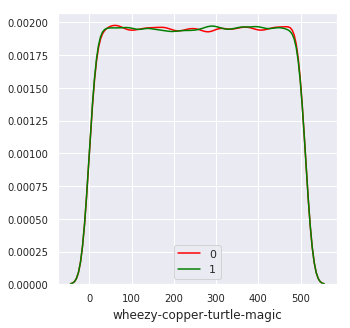

In [10]:
fig = plt.figure(figsize=(5,5))
sns.distplot(df_train[df_train['target']>0]['wheezy-copper-turtle-magic'], hist=False,label='0', color='red')
sns.distplot(df_train[df_train['target']==0]['wheezy-copper-turtle-magic'], hist=False,label='1', color='green')
plt.xlabel('wheezy-copper-turtle-magic', fontsize=12)
locs, labels = plt.xticks()
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=10)

In [11]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1, color='red')
        sns.distplot(df2[feature], hist=False,label=label2, color='green')
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

<Figure size 432x288 with 0 Axes>

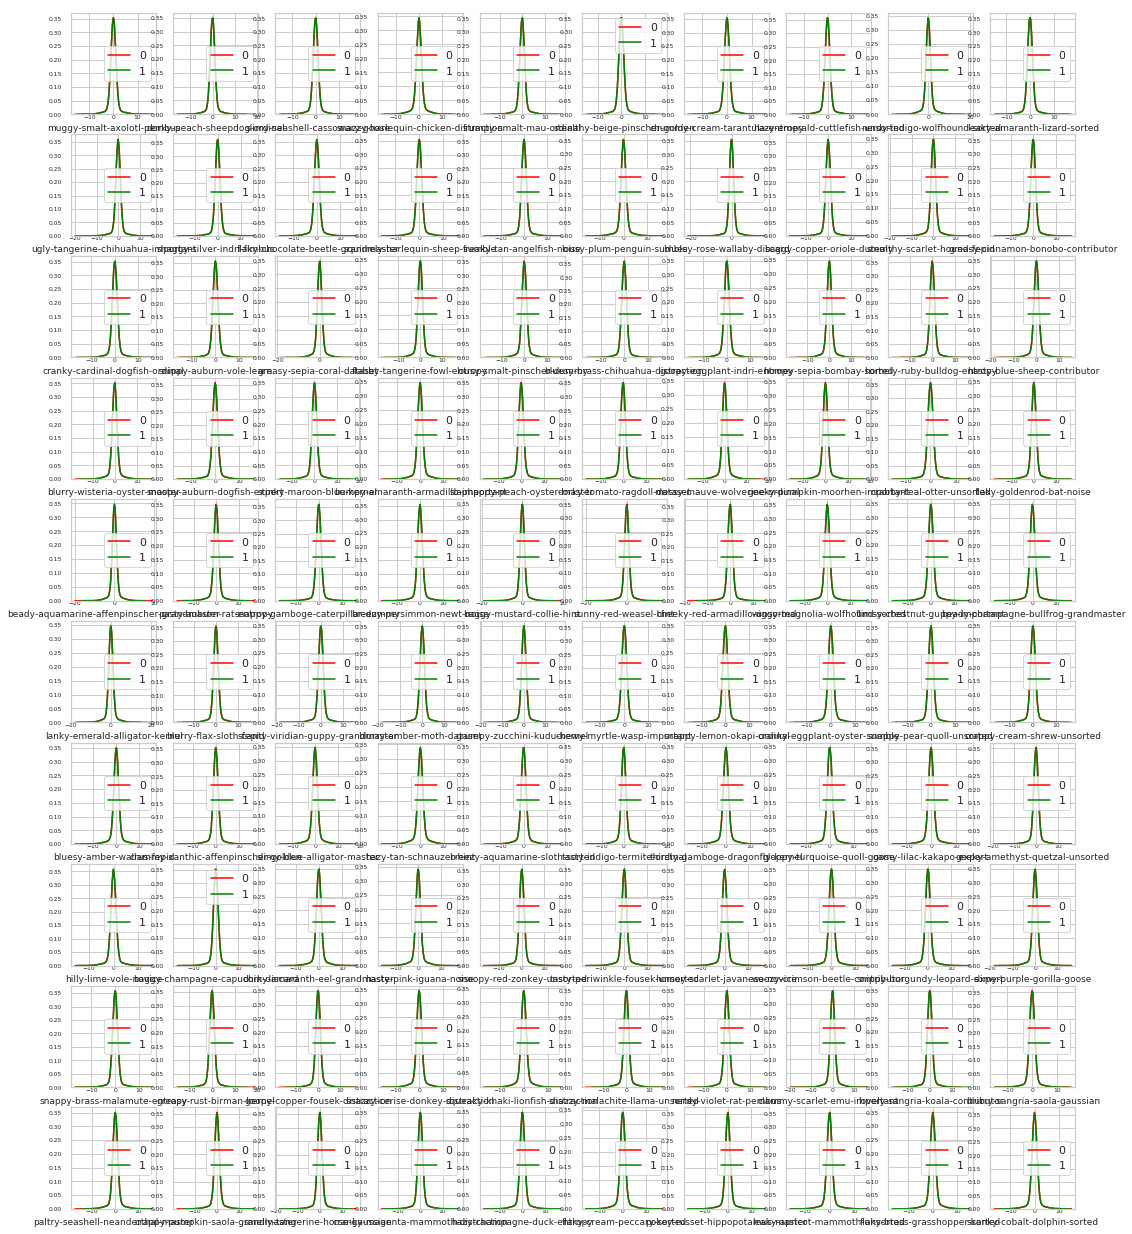

In [12]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
features = df_train.columns.values[1:101]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

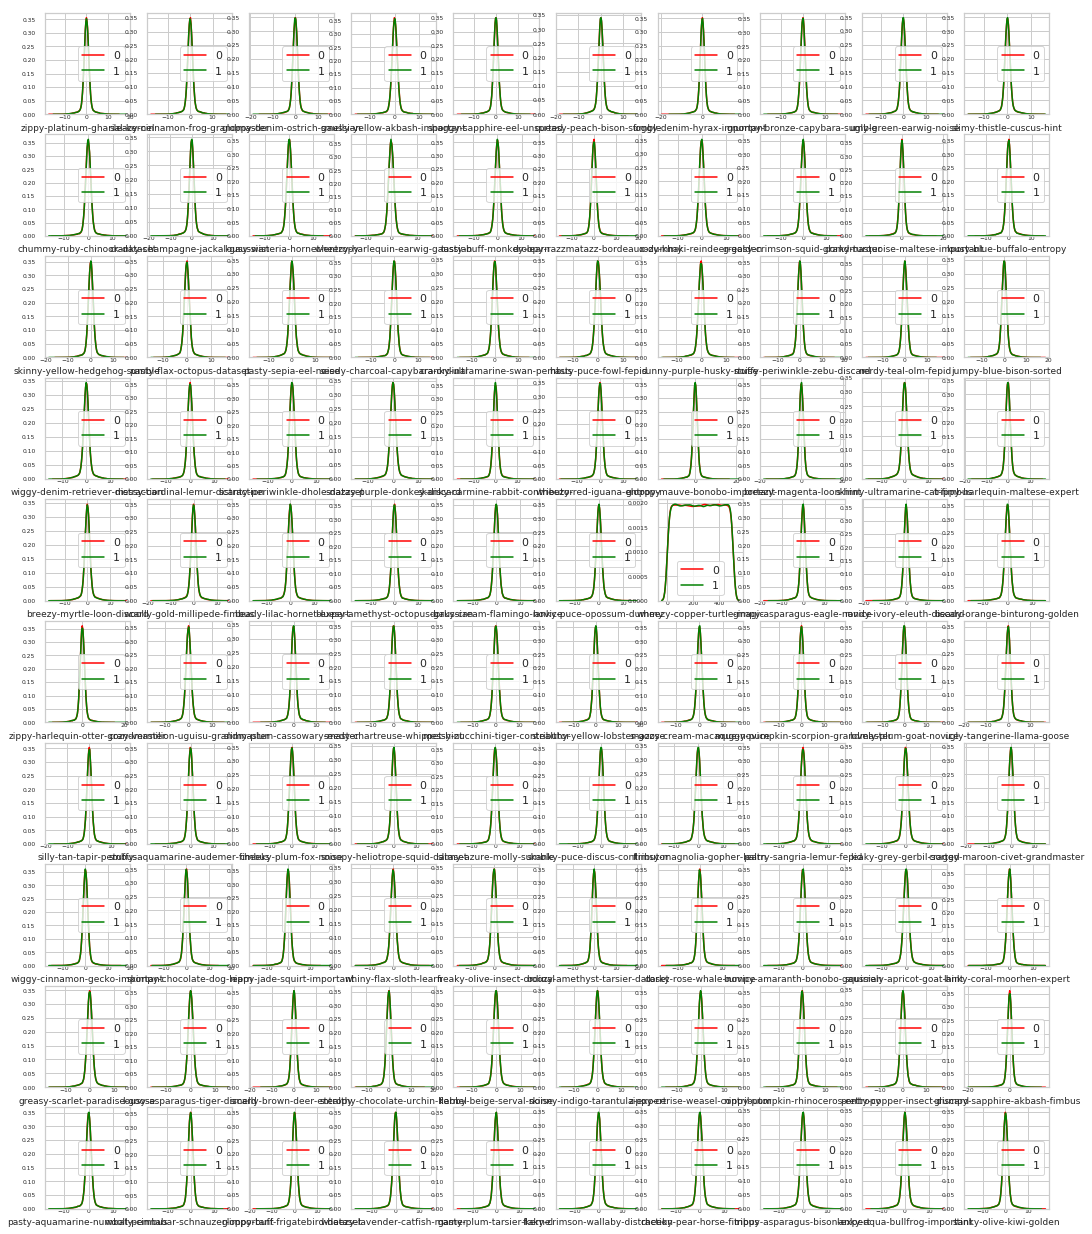

In [13]:
features = df_train.columns.values[101:201]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

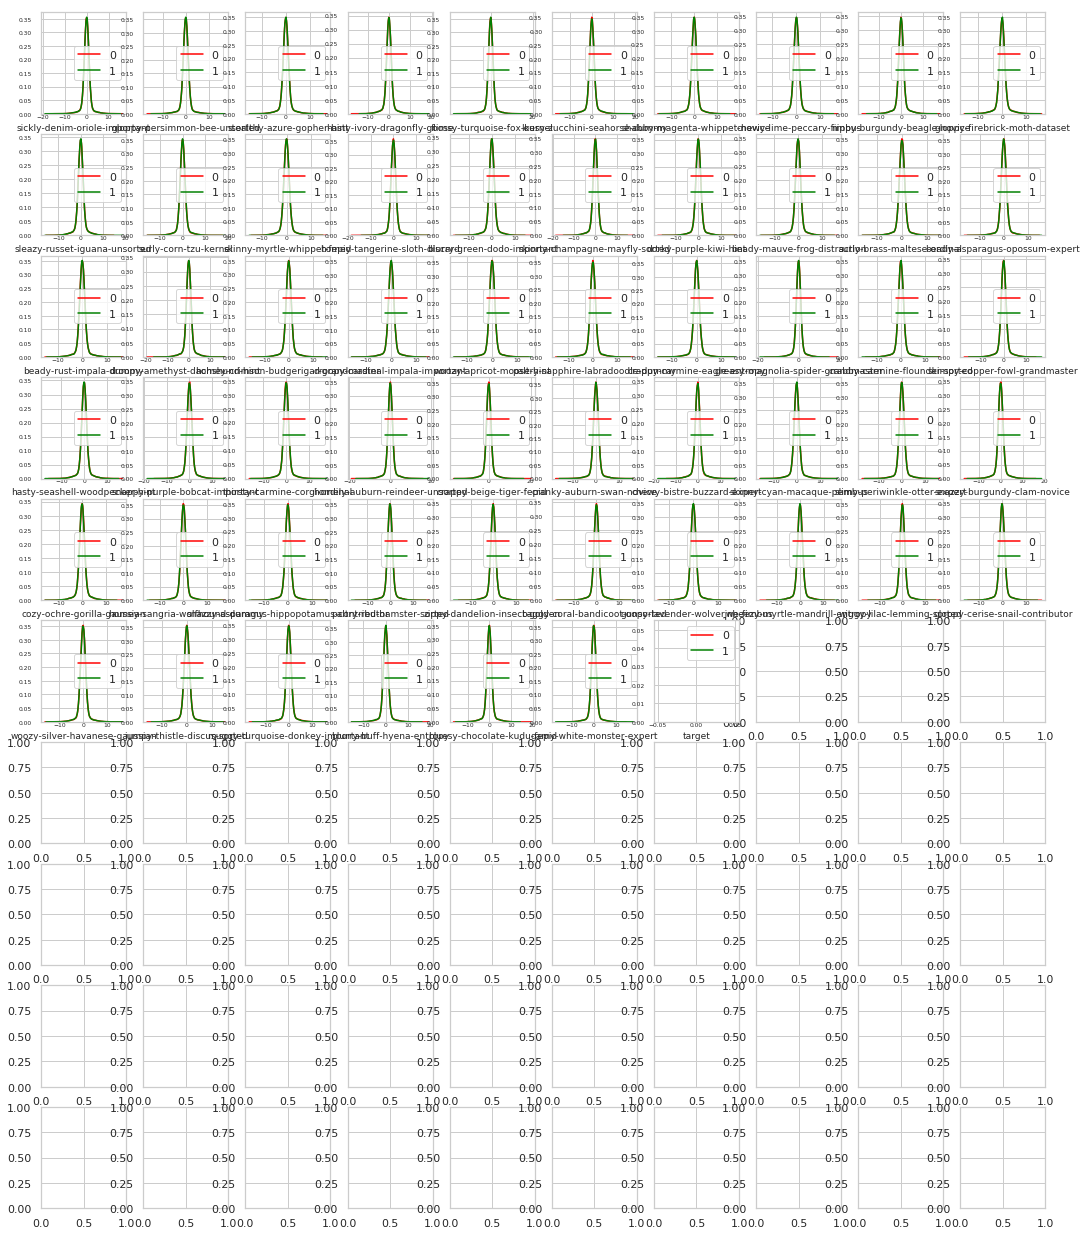

In [14]:
features = df_train.columns.values[201:]
plot_feature_distribution(t0, t1, '0', '1', features)

Let's try frequency encoding!

In [15]:
def get_count(df):
    '''
    Function that adds one column for each variable (excluding 'id', 'target')
    populated with the value frequencies
    '''
    for var in [i for i in df.columns if i not in ['id','target']]:
        df[var+'_count'] = df.groupby(var)[var].transform('count')
    return df

In [16]:
start = time.time()
df_train_count = get_count(df_train)
end = time.time()
print('It took %.2f seconds\nShape: ' %(end - start))
print(df_train_count.shape)

It took 115.96 seconds
Shape: 
(262144, 514)


In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import catboost as ctb

In [18]:
# List of all the features
features = [c for c in df_train_count.columns if c not in ['id', 'target']]
len(features)

512

In [19]:
X_train_count = df_train_count[features]
y_train_count = df_train.loc[:,'target']

In [20]:

# 0.8 train, 0.2 dev
X_train,X_valid,y_train,y_valid = train_test_split(X_train_count, y_train_count, test_size=0.2, random_state=42, stratify=y_train_count)

print('X_train shape: {}\n'.format(X_train.shape))
print('y_train shape: {}\n'.format(y_train.shape))
print('X_valid shape: {}\n'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))

X_train shape: (209715, 512)

y_train shape: (209715,)

X_valid shape: (52429, 512)

y_valid shape: (52429,)


In [21]:
cat_params = {
        'max_depth' : 3,
        'learning_rate' : 0.09,
        'colsample_bylevel' : 1.0,
        'objective' : "Logloss",
        'eval_metric' : 'AUC',
        'task_type' : "GPU",
        'random_seed': 42,
        'iterations': 100000,
        'use_best_model': True
 }

In [22]:
%%time
clf = ctb.CatBoostClassifier(**cat_params)
clf.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], verbose=5000, early_stopping_rounds = 1500)
end = time.time()

val_pred = clf.predict_proba(X_valid)[:,1]
print(">> CV score: {:<8.5f}".format(roc_auc_score(y_valid, val_pred)))

0:	learn: 0.5051887	test: 0.5054697	best: 0.5054697 (0)	total: 39.4ms	remaining: 1h 5m 36s
5000:	learn: 0.7956250	test: 0.5703365	best: 0.5703882 (4967)	total: 1m 5s	remaining: 20m 51s
10000:	learn: 0.8809468	test: 0.5833424	best: 0.5833972 (9977)	total: 2m 9s	remaining: 19m 26s
15000:	learn: 0.9267496	test: 0.5919029	best: 0.5919029 (15000)	total: 3m 12s	remaining: 18m 8s
20000:	learn: 0.9535872	test: 0.5986425	best: 0.5986834 (19938)	total: 4m 16s	remaining: 17m 4s
25000:	learn: 0.9700788	test: 0.6045727	best: 0.6045808 (24938)	total: 5m 17s	remaining: 15m 53s
30000:	learn: 0.9807761	test: 0.6092989	best: 0.6093659 (29692)	total: 6m 20s	remaining: 14m 47s
35000:	learn: 0.9877614	test: 0.6124139	best: 0.6124992 (34815)	total: 7m 25s	remaining: 13m 47s
40000:	learn: 0.9922627	test: 0.6158038	best: 0.6158605 (39926)	total: 8m 29s	remaining: 12m 43s
45000:	learn: 0.9951489	test: 0.6189829	best: 0.6189898 (44998)	total: 9m 32s	remaining: 11m 39s
50000:	learn: 0.9969696	test: 0.6202242	bes

In [23]:
#submit = pd.read_csv('../input/sample_submission.csv')
#submit["target"] = predictions
#submit.to_csv("submission.csv", index=False)